# 多項近似のバイアスとバリアンスを計算する。

- h(x) の代わりに観測値を使ってバイアス、バリアンスを計算する。
- xについては平均をとる
- 多項式の次元を `p = 1, 3, 6, 10`  の次数ごとに計算をしてもっとも良い次数を求める。
- このときパラメータは線形回帰で求める。

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yoh

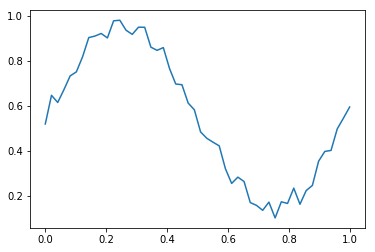

In [2]:
def get_data() -> np.ndarray:
    '''
    データセットを取得します。
    '''
    x_size = 50
    error = np.random.random(x_size) * 0.1
    vec_x = np.linspace(0, 1, x_size)
    vec_f = 0.5 + 0.4 * np.sin(2*np.pi*vec_x) + error
    return vec_x, vec_f

vec_x, vec_f = get_data()

plt.plot(vec_x, vec_f)
plt.show()

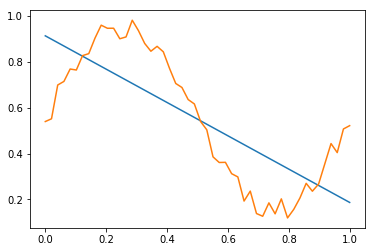

In [3]:
def fit(vec_x, vec_y, p):
    '''
    yについて、xを用いて次数pの多項式近似をします。
    '''
    vec_w = np.polyfit(vec_x, vec_y, p)
    vec_h = np.poly1d(vec_w)(vec_x)
    return vec_x, vec_h

vec_x, vec_y = get_data()
vec_x, vec_h = fit(vec_x, vec_y, 1)
plt.plot(vec_x, vec_h)
plt.plot(vec_x, vec_y)
plt.show()


In [4]:
def cal_bias(vec_h, vec_y):
    '''
    バイアスを計算します
    '''
    mean_y = vec_y.mean()
    item = mean_y - vec_h
    return np.mean(item ** 2)

def cal_variance(vec_h):
    '''
    バリアンスを計算します
    '''
    mean_h = vec_h.mean()
    item = vec_h - mean_h ** 2
    return np.mean(item)

vec_x, vec_y = get_data()
vec_x, vec_h = fit(vec_x, vec_y, 1)
bias = cal_bias(vec_h, vec_y)
variance = cal_variance(vec_h)

print(bias)
print(variance)

0.04638861540944479
0.24742822042116797


In [5]:
class Aggregator():
    '''
    情報を貯蓄して解析する集積器です。
    内部でキーに対応したリストを保持しています。
    '''
    def __init__(self):
        self.values = {}

    def savings(self, key, value):
        '''
        値をキーに対応したリストに保存します。
        '''
        if key not in self.values:
            self.values[key] = []
        self.values[key].append(value)
        pass
    
    def total(self):
        '''
        貯蓄した値を集計します。
        '''
        dict_result = {}
        for key in self.values:
            info = {}
            info['mean'] = np.array(self.values[key]).mean()
            info['var'] = np.array(self.values[key]).var()
            dict_result[key] = info
        return pd.DataFrame.from_dict(dict_result).T
    
    def destory(self):
        '''
        貯蔵した値を破棄します。
        '''
        self.values = {}

memory = Aggregator()
memory.savings('key1', 1)
memory.savings('key1', 2)
memory.savings('key2', 3)
print(memory.values)

{'key1': [1, 2], 'key2': [3]}


In [6]:
def run(list_p, memory):
    '''
    設定した次数ごとにバイアスをバリアンスを計算してメモリーに保存します。
    '''
    for p in list_p:
        vec_x, vec_y = get_data()
        vec_x, vec_h = fit(vec_x, vec_y, p)
        bias = cal_bias(vec_h, vec_y)
        variance = cal_variance(vec_h)
        memory.savings(str(p)+'#bias', bias)
        memory.savings(str(p)+'#variance', variance)
    return memory

memory = Aggregator()
list_p = [1, 3, 6, 10]

memory = run(list_p, memory)
memory.total()

,mean,var
1#bias,0.045456,0.0
1#variance,0.247595,0.0
3#bias,0.074125,0.0
3#variance,0.246689,0.0
6#bias,0.078719,0.0
6#variance,0.247519,0.0
10#bias,0.074897,0.0
10#variance,0.247702,0.0


In [10]:
def main():
    memory = Aggregator()
    list_p = [1, 3, 6, 10]
    iter_num = 100
    for i in range(iter_num):
        memory = run(list_p, memory)
    display(memory.total())
    
main()

,mean,var
1#bias,0.045162,3.232864e-06
1#variance,0.247491,1.741028e-07
3#bias,0.077555,5.369829e-06
3#variance,0.247427,2.000744e-07
6#bias,0.078727,4.775366e-06
6#variance,0.247436,1.916562e-07
10#bias,0.078585,5.296087e-06
10#variance,0.247525,1.685335e-07
